In [96]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
import torch
from sklearn import metrics
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import argparse
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [97]:
input_dir = '/data/leslie/suny4/processed_input'
atac_dir = osp.join(input_dir, 'atac')
chrom = 1
ct = 'mycGCB_am_gfp_myc_gcb_thelp_sample'
start = 12345

In [137]:
def load_ctcf(ctcf_path, chrom, start):
    ctcf_all = pickle.load(open(ctcf_path, 'rb'))
    ctcf = ctcf_all['chr{}'.format(chrom)].toarray()[0][start*200: (start+700)*200]

    return ctcf


def load_atac(atac_path, chrom, start):
    atac_all = pickle.load(open(atac_path, 'rb'))
    atac = atac_all['chr{}'.format(chrom)].flatten()[start*200: (start+700)*200]

    return atac


def load_scatac(scatac_path, metacell_path, chrom, start):
    scatac_pre = pickle.load(open(scatac_path, 'rb'))['chr{}'.format(chrom)]
    metacell = csr_matrix(pd.read_csv(metacell_path, index_col=0).values)
    tmp = torch.tensor((metacell * scatac_pre)[:, start*20:(start+700)*20].toarray()).T

    size, eps = tmp.shape[1], 1e-8
    one, zero = torch.tensor(1.0), torch.tensor(0.0)
    lrg = torch.where(tmp>0, one, zero)
    eql = torch.where(tmp==0, one, zero)
    num, denom = lrg @ lrg.T, size - eql @ eql.T
    scatac = torch.div(num, torch.max(denom, eps * torch.ones_like(denom)))
    scatac[scatac != scatac] = 0

    scatac = scatac.reshape(
        scatac.shape[0]//20, 20, -1
    ).mean(axis=1).reshape(
        -1, scatac.shape[1]//20, 20
    ).mean(axis=2)

    return scatac


def load_multiome(input_dir, ct, chrom, start, genome='mm10'):
    ctcf_path = osp.join(input_dir, 'dna', '{}_ctcf_motif_score.p'.format(genome))
    atac_path = osp.join(input_dir, 'atac', '{}_tile_pbulk_50bp_dict.p'.format(ct))
    scatac_path = osp.join(input_dir, 'atac', '{}_tile_500bp_dict.p'.format(ct))
    metacell_path = osp.join(input_dir, 'atac', '{}_metacell_mask.csv'.format(ct))

    ctcf = load_ctcf(ctcf_path, chrom, start)
    atac = load_atac(atac_path, chrom, start)
    scatac = load_scatac(scatac_path, metacell_path, chrom, start)

    return ctcf, atac, scatac


def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]

In [143]:
ctcf_path = '/data/leslie/suny4/processed_input/dna/mm10_ctcf_motif_score.p'
ctcf = pickle.load(open(ctcf_path, 'rb'))['chr1'].toarray()[0]

[]

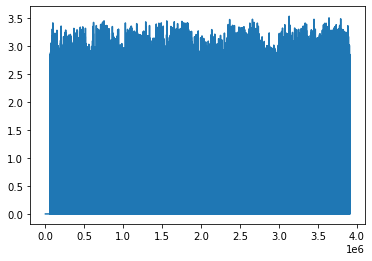

In [144]:
plt.plot(ctcf)
plt.plot()

In [145]:
ctcf.shape

(3909440,)